# RL for optimal chemotherapy delivery

Based on:

1) https://arxiv.org/pdf/1904.01200.pdf


In [ ]:
!pip install control
!pip install stable-baselines3[extra]

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# !pip install control
import control
import control.optimal as opt

import gym
from gym import Env, spaces
import time

import torch as th

import scipy.integrate as integrate
import scipy.stats as stats


# !pip install stable-baselines3[extra]
import stable_baselines3 as sb3
from stable_baselines3 import DDPG, PPO, DQN, A2C
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_checker import check_env

## Model

Clinical reinforcement trials:

* A finite, reasonably small set of decision times is identified
* For each decision time, a set of possible treatments (continuous or finite)
* A utility function (cost) that can be evaluated at each time point and contains a weighted combination of outcomes

Here, we are interested in the specific case of chemotherapy for cancer treatment.

The model used to simulate such a trial in Paper 1 is defined as follows:

$$
\begin{aligned}
&\dot{N}(t)=r_{2} N(t)\left(1-b_{2} N(t)\right)-c_{4} N(t) T(t)-a_{3} N(t) C(t) \\
&\dot{T}(t)=r_{1} T(t)\left(1-b_{1} T(t)\right)-c_{2} I(t) T(t)-c_{3} T(t) N(t)-a_{2} T(t) C(t) \\
&\dot{I}(t)=s+\frac{\rho I(t) T(t)}{\alpha+T(t)}-c_{1} I(t) T(t)-d_{1} I(t)-a_{1} I(t) C(t) \\
&\dot{C}(t)=-d_{2} C(t)+u(t)
\end{aligned}
$$

with $N(0)=N_{0}, T(0)=T_{0}, I(0)=I_{0}, C(0)=C_{0}$ and $t \geq 0$

where 
 - $I(t)$ is the number of immune cells
 - $N(t)$ is the number of normal cells
 - $T(t)$ is the number of tumor cells
 - $C(t)$ is the drug concentration. 
 - $u(t)\left[\mathrm{mg} \cdot l^{-1} \cdot\right.$ day $^{-1}$ ] is the action or control is the chemotherapy drug infusion rate

All other variables are fixed. Let us now generate data following this model (firstly using the same constant values as them, and sampling initial values from the same distributions).

In [3]:
# values fixed in paper
a1, a2, a3 = 0.2, 0.3, 0.1
b1, b2 = 1, 1
c1, c2, c3, c4 = 1, 0.5, 1, 1
d1, d2 = 0.2, 1
r1, r2 = 1.5, 1
s = 0.33
alpha, rho = 0.3, 0.01

params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)

# transition equations
def f(x, u, params):
  (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho) = params
  (n, t, i, c) = x
  # sytem of ODEs
  n_dot = r2*n*(1-b2*n) - c4*n*t - a3*n*c
  t_dot = r1*t*(1-b1*t) - c2*i*t - c3*t*n - a2*t*c
  i_dot = s + (rho*i*t)/(alpha+t) - c1*i*t - d1*i - a1*i*c
  c_dot = -d2*c + u
  return np.array([n_dot, t_dot, i_dot, c_dot])

def g(x):
  G = np.array([0., 0.2, 0., 0.])
  return G*x


def process(f, g, x, u, w, tf, dt, params=params):
  """
  f : transition function
  g : diffusion term
  x : state at time t
  u : control at time t
  w : weiner process at time t
  dt : discretization
  """
  # define weiner process for tumor cells
  y = np.random.normal()
  dw = w + y/np.sqrt(tf)
  return f(x, u, params)*dt + g(x)*dw, dw

def r0(x, dt):
  (n, t, i, c) = x
  return -dt*t

def r(x, dt):
  (n, t, i, c) = x
  return dt*(-t-0.5*(n<0.4)-0.5*(i<0.4))



In [4]:
def simulate(f, g, T, dt, x0, u0, policy, model_params=params):

  all_x = np.zeros((len(x0), len(horizon)))
  all_u = np.zeros(len(horizon))

  x, u = x0, u0
  w = x0[1]
  for i in range(T):
    x_dot, w = process(f, g, x, u, w, T, dt, model_params)
    x = np.maximum(np.zeros(4), x+x_dot)
    u = policy(x)

    all_x[:, i] = x
    all_u[i] = u
  
  return all_x, all_u

def plot_action(u, horizon):
  fig, ax = plt.subplots(figsize=(6, 5))
  ax.plot(horizon, u, label='policy')
  ax.set_xlabel('time in days')
  ax.set_ylabel('u [mg/l day]')
  plt.legend()
  plt.show()

def plot_states(x, horizon):
  fig, ax = plt.subplots(figsize=(6, 5))
  ax.plot(horizon, x[0, :], label='N(t)')
  ax.plot(horizon, x[1, :], label='T(t)')
  ax.plot(horizon, x[2, :], label='I(t)')
  ax.set_xlabel('time [days]')
  ax.set_ylabel('number of cells')
  plt.legend()
  plt.show()

In [5]:
def null_policy(x):
  return 0

def random_policy(x):
  return np.random.uniform(0, 10)

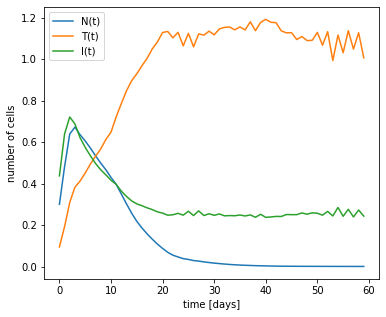

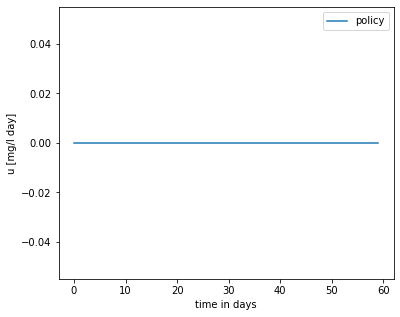

In [7]:
dt = 1
T = 60
horizon = np.arange(0, T, dt)
x0 = [1., 0.7, 1., 0]
u0 = 0

x1, u1 = simulate(f, g, T, dt, x0, u0, policy=null_policy)

plot_states(x1, horizon)
plot_action(u1, horizon)

## OpenAI Gym framework

We now write our system as a Gym environment.

In [8]:
class Trial(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, model, T, dt, x0, discrete=False):
    super(Trial, self).__init__()

    # model dictionary
    self.transition = model['transition']
    self.diffusion = model['diffusion']
    self.params = model['params']

    # define action and observation spaces
    self.discrete = discrete
    if self.discrete:
      self.action_space = spaces.Discrete(10)
    else:
      self.action_space = spaces.Box(low=0, high=10, shape=(1,))
    self.observation_space = spaces.Box(low=0, high=np.array([2, 2, 2, 10]), shape=(4,))

    # initialize state
    self.x0 = x0
    self.state = np.array(x0).astype(np.float32)

    # intialize weiner process
    self.w = x0[1]

    # initialize time
    self.T = T
    self.dt = dt
    self.t = 0

  def step(self, action):
    # Execute one time step within the environment
    # action must be list or array
    # Must return obs, reward, done, info
    if self.discrete:
      u = action
    else:
      u = action[0]
    reward = r(self.state, self.dt)
    dx, dw = process(self.transition, self.diffusion, self.state, u, self.w, self.T, self.dt, self.params)
    new_state = np.maximum(np.zeros(4), self.state + dx)
    self.state = new_state.astype(np.float32)
    self.w = dw
    self.t += self.dt

    #Done when time runs out
    done=True if self.t > self.T else False
    # done=True if self.t > self.T else False
    # Optionally we can pass additional info, we are not using that for now
    info = {}

    return self.state, reward, done, info
    

  def reset(self):
    # Reset the state of the environment to an initial state
    self.t = 0
    self.state = np.array(x0).astype(np.float32)

    return self.state

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    print("t={}, N: {:.2f}, T: {:.2f}, I: {:.2f}, C: {:.2f}".format(self.t,self.state[0], self.state[1], self.state[2], self.state[3]))

### Simulating the environment

Simulating and checking that the environment is [stable-baseline3](https://stable-baselines3.readthedocs.io/en/master/index.html) compatible:

In [9]:
cell_model = {'transition': f, 'diffusion': g, 'params': params}
x0 = [1, 0.7, 0.1, 0]
T = 60 # number of days in trial
dt = 1 # update interval (in days)

In [16]:
#Simulate environment
env = Trial(cell_model, T, dt, x0)
#T = 0
#Generate initial drug level from uniform distribution (0.5,1) to account
# for a minimum level at the beginning (0.5)
dose0 = env.reset()[1]
action = [0.] #First action (first drug dose)
env.render()
for t in range(T):
  env.step(action)
  env.render()
  action = env.action_space.sample()
  while action[0]==0: action = env.action_space.sample() #Make sure action is not 0
  if env.state[1]==0: 
    print("Tumor completely absorbed")
    break

check_env(env)

t=0, N: 1.00, T: 0.70, I: 0.10, C: 0.00
t=1, N: 0.30, T: 0.38, I: 0.34, C: 0.00
t=2, N: 0.39, T: 0.62, I: 0.47, C: 0.12
t=3, N: 0.38, T: 0.67, I: 0.41, C: 2.07
t=4, N: 0.29, T: 0.33, I: 0.22, C: 9.93
t=5, N: 0.11, T: 0.00, I: 0.00, C: 0.61
Tumor completely absorbed


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/env_checker.py:273: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


## Training the Model

In [17]:
%load_ext tensorboard

In [ ]:
log_path = os.path.join("training", "logs")
if not os.path.exists(log_path):
  os.makedirs(log_path)
  
import tensorflow as tf
%tensorboard --logdir './training/logs'



In [19]:
def discrete_policy(model):
  return lambda x: model.predict(x)[0]

def continuous_policy(model):
  return lambda x: model.predict(x)[0][0]

In [20]:
# params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)
# x0 = [1., 0.7, 1., 0]
# env = Trial(cell_model, T, dt, x0)
# model1 = PPO('MlpPolicy', env, verbose=1, device='auto', tensorboard_log=log_path)
# model1.learn(total_timesteps=100000, tb_log_name='ppo')

### DQN: Deep Q Network

[Documentation](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#notes)

In [ ]:
params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)
cell_model = {'transition': f, 'diffusion': g, 'params': params}
x0 = [1, 0.7, 0.1, 0]
T = 60 # number of days in trial
dt = 1 # update interval (in days)

env_dqn = Trial(cell_model, T, dt, x0, discrete=True)
# Custom actor (pi) and value function (vf) networks
# of two layers of size 32 each with Relu activation function
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[128, 128])

dqn_model = DQN("MlpPolicy", env_dqn, learning_rate=1e-5, verbose=1, device='auto', tensorboard_log=log_path, policy_kwargs=policy_kwargs)
dqn_model.learn(total_timesteps=200000, tb_log_name='dqn')

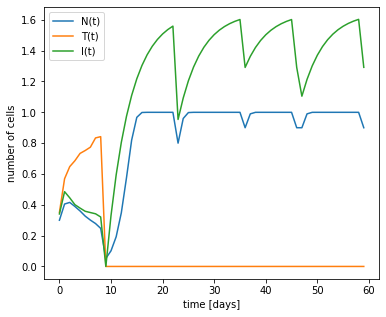

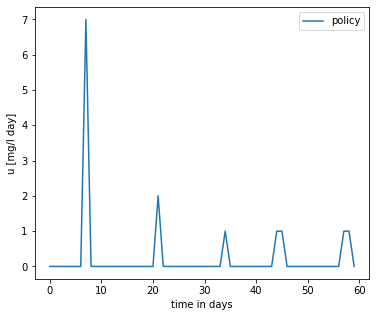

In [46]:
u0 = 0
x1, u1 = simulate(f, g, T, dt, x0, u0, policy=discrete_policy(dqn_model), model_params=cell_model['params'])

plot_states(x1, horizon)
plot_action(u1, horizon)

In [ ]:
params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)
x0 = [1., 0.7, 1., 0]
env_ddpg = Trial(cell_model, T, dt, x0, discrete=False)
# Custom actor (pi) and value function (vf) networks
# of two layers of size 32 each with Relu activation function
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[128, 128])

ddpg_model = DDPG("MlpPolicy", env_ddpg, gamma=0.995, verbose=1, device='auto', tensorboard_log=log_path, policy_kwargs=policy_kwargs)
ddpg_model.learn(total_timesteps=100000, tb_log_name='ddpg')

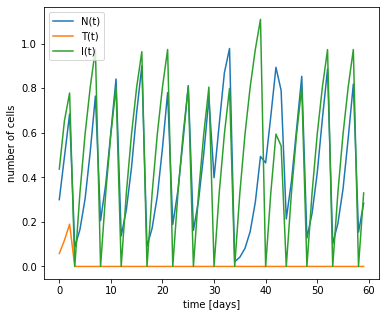

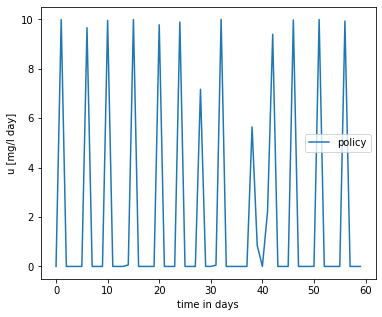

In [54]:
x1, u1 = simulate(f, g, T, dt, x0, u0, policy=continuous_policy(ddpg_model), model_params=cell_model['params'])

plot_states(x1, horizon)
plot_action(u1, horizon)

In [ ]:
params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)
x0 = [1., 0.7, 1., 0]
env_ppo = Trial(cell_model, T, dt, x0, discrete=False)
# Custom actor (pi) and value function (vf) networks
# of two layers of size 32 each with Relu activation function
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[128, 128, 128])

ppo_model = PPO("MlpPolicy", env_ppo, verbose=1, device='auto', tensorboard_log=log_path, policy_kwargs=policy_kwargs)
ppo_model.learn(total_timesteps=100000, tb_log_name='ppo')

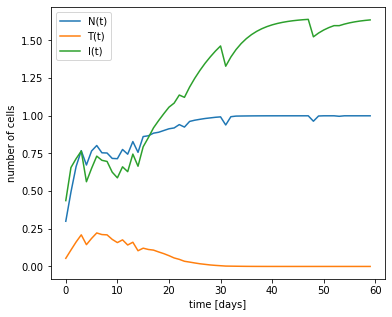

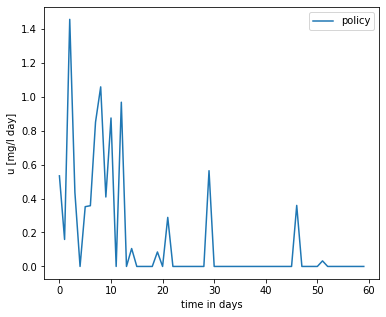

In [96]:
x1, u1 = simulate(f, g, T, dt, x0, u0, policy=continuous_policy(ppo_model), model_params=cell_model['params'])

plot_states(x1, horizon)
plot_action(u1, horizon)

In [ ]:
params = (a1, a2, a3, b1, b2, c1, c2, c3, c4, d1, d2, r1, r2, s, alpha, rho)
x0 = [1., 0.7, 1., 0]
env_a2c = Trial(cell_model, T, dt, x0, discrete=False)
# Custom actor (pi) and value function (vf) networks
# of two layers of size 32 each with Relu activation function
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[128, 128])

a2c_model = PPO("MlpPolicy", env_a2c, verbose=1, device='auto', tensorboard_log=log_path, policy_kwargs=policy_kwargs)
a2c_model.learn(total_timesteps=200000, tb_log_name='a2c')

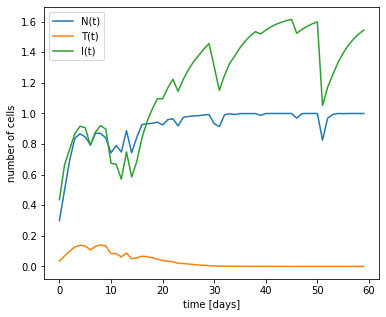

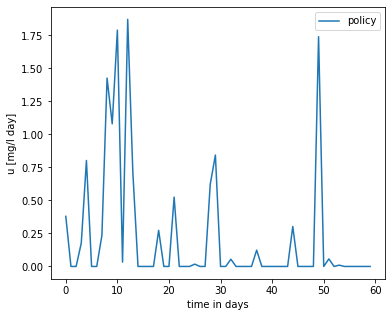

In [68]:
x1, u1 = simulate(f, g, T, dt, x0, u0, policy=continuous_policy(a2c_model), model_params=cell_model['params'])

plot_states(x1, horizon)
plot_action(u1, horizon)